## Modulador ASK

Se escoge un modulador de orden 4, con 4 símbolos. La asignación es la misma que la utilizada para el modulador PAM. Para este modulador se utiliza una primera etapa en la que se obtiene la amplitud de modulación y luego se multiplica por una portadora. De forma que en este código se llama a la función del modulador PAM y se multiplica por una portadora en seno. Es necesario determinar una frecuencia para esta portadora.

La frecuencia de la portadora se determina según la limitación que se tiene de que debe ser mayor que 1/t_simb.

In [1]:
def modulador_PAM (bc_l):
    '''
    Modulador ASK: utiliza un modulador PAM y multiplica por una señal portadora de frecuencia fc.

    @param bc_l: Bits del codificador de canal
    @param fs: Frecuencia de la portadora
    @param tiempo_simbolo: El tiempo de duración de cada símbolo

    return x_t: Señal transmitida al canal
    return tiempo: Vector de tiempo de la señal

    Codificación utilizada:
    00 - 6
    01 - 4
    11 - 2
    10 - 0
    '''
    
    # Paso 1
    agrupacion_bits = np.split(bc_l, len(prueba)/2)
    
    # Paso 2
    a_n = [] 
    
    for bits in agrupacion_bits:
        if bits[0] == 0:
            if bits[1] == 0:
                simbolo = 6
            else:
                simbolo = 4
        else:
            if bits[1] == 1:
                simbolo = 2
            else:
                simbolo = 0
        a_n.append(simbolo)
        
    # Paso 3
    p = np.ones(24)
    
    # Paso 4 y 5
    arrayOfxn_k = []
    
    for simbolo in a_n:
        xn_k = simbolo*p
        arrayOfxn_k.append(xn_k)
    
    # Paso 6
    x_k = np.concatenate(arrayOfxn_k, axis=None)
    
    return x_k.astype(int)

In [2]:
def modulador_ASK (bc_l, fs, tiempo_simbolo):
    '''
    Modulador ASK: utiliza un modulador PAM y multiplica por una señal portadora de frecuencia fc.
    '''
    
    # Modulación de la amplitud
    bcT = modulador_PAM (bc_l)
    
    # Muestreo de amplitud
    i = 3 # Para muestrear el valor de cada símbolo en el de la posición 4, son 24 valores de amplitud por símbolo
    contador_simbolo = 0
    simbolos = [0] * (int(np.size(bcT, axis=0)/24)) # 24 porque son 24 valores de amplitud por símbolo
    
    while i < np.size(bcT, axis=0):
        simbolos[contador_simbolo] = bcT[i]
        contador_simbolo += 1
        i += 24
        
    print(simbolos)
    
    # Definición de señal portadora
    tiempo = np.arange(0, tiempo_simbolo, (t_simb*2/fs))# se utiliza frecuencia de muestreo de nyquist ajustada al tiempo de símbolo
    c_t = np.sin(2 * np.pi * fs * tiempo)
    #plt.plot(tiempo, c_t)
    
    # Modulación en el tiempo
    i = 0
    arrayOfx_t = [0] * (len(simbolos))

    for simbolo in simbolos:
        arrayOfx_t[i] = c_t * simbolo
        i += 1
    
    x_t = np.concatenate(arrayOfx_t, axis=None)
    tiempo = len(x_t)
    x_t_array = np.asarray(x_t)
    
    return x_t_array, tiempo

## Canal ruidoso

Esta función modela un canal con ruido, como lo existe en todos los medios de comunicación. El ruido que se añade por este canal es por medio de la distribución normal, que se conoce como Ruido Blanco Gaussiano Aditivo, AWGN por sus siglas en inglés. Este ruido se le suma a la señal generada por el modulador PAM>

In [3]:
import numpy as np

def canal_ruidoso(senal_Tx, snr=0.2):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso).

    @param senal_Tx: El vector del modulador
    return sneal_Rx: La señal modulada al dejar el canal
    '''

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, 1/snr, senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

## Demodulación ASK

Esta demodulación ASK se parece en gran manera a la de PAM. La diferencia radica en el muestreo de la señal recibida. En este caso, como se está trabajando con una señal portadora seno, el muestreo realizado se realiza en los máximos y mínimos. Esto debido a que en estos puntos se halla el valor del símbolo que se envió, por ello se obtiene sus valores, los mínimos (negativos) se pasan a positivo con la función abs() y seguidamente se promedian los valores muestreados. Esta lista de valores promediados son los utilizados para proceder a la decisión de en qué símbolo consiste la información recibida. Los pasos siguientes son iguales a la ya vista demodulación PAM.

In [4]:
def demod_ASK(senal_xR, cant_simb, t_simb, fs):
    '''
    Función de demodulación ASK. Realiza un muestreo de la señal, decide que símbolo le asigna y finalmente pasa el símbolo a bits.

    @param senal_xR: Señal proveniente del canal ruidoso.
    @param cant_simb = Cantidad de símbolos enviados (información)
    @param t_simb: Tiempo de duración de cada símbolo.
    @param fs: Frecuencia de la portadora.

    return bits_recuperados: Los bits obtenidos del canal, después de la adición de ruido. Idealmente se corrigen en el decodificador de canal.
    '''
    # 1. Se divide la señal recibida en sublistas, donde cada una contiene todos los valores de un símbolo
    arrayOfSymbolsValue = np.split(senal_xR, cant_simb)

    # 2. Creo el vector tiempo, que es la duración de cada símbolo
    tiempo_demod = np.arange(0, t_simb, (t_simb*2/fs))

    # 3. Vector de símbolos muestreados
    array_simb = []

    # 4. Loop que obtiene los valores de los picos de la señal para cada símbolo. Con picos nos referimos
    # a los valores máximos y mínimos de la señal recibida. Como la portadora es un seno, los picos se dan
    # en pi/2 y 3pi/2.

    for senal_simb in arrayOfSymbolsValue:
        # Los picos se dan en valores impares de n
        n = 1
        # Array con los valores obtenidos
        muestreo = []
        for pos, val in enumerate(tiempo_demod):
            # Se revisa cuando el tiempo está en el rango donde se produce un pico
            if val > (n/(4*fs))*0.99 and val < (n/(4*fs))*1.01:
                # Se guarda en el array el valor de señal correspondiente a ese tiempo
                muestreo.append(senal_simb[pos])
                n += 2
            # Se pasan los valores a positivo y se promedia
            muestreo_abs = np.absolute(muestreo)
            muestreo_prom = np.mean(muestreo_abs)
            array_simb.append(muestreo_prom)

    
    # 5. Con las muestras promediadas, se decida a cuál símbolo se asocia
    nuevos_simbolos = []
    for prom_simb in array_simb:
        if prom_simb < 1:
            nuevos_simbolos.append(0)
        elif prom_simb >= 1 and prom_simb < 3:
            nuevos_simbolos.append(2)
        elif prom_simb >= 3 and prom_simb < 5:
            nuevos_simbolos.append(4)
        else:
            nuevos_simbolos.append(6)
            
    # 4. Pasamos los símbolos a bits
    bits_recuperados = []
    
    for simbolo in nuevos_simbolos:
        if simbolo == 0:
            bits_recuperados.append([1, 0])
        elif simbolo == 2:
            bits_recuperados.append([1, 1])
        elif simbolo == 4:
            bits_recuperados.append([0, 1])
        else:
            bits_recuperados.append([0, 0])
            
    bits_recuperados = np.concatenate(bits_recuperados, axis=None)

    return bits_recuperados.astype(int)

In [5]:
import numpy as np
# Visualizar datos
import matplotlib.pyplot as plt

prueba = np.array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

# Modulación ASK
t_simb = 0.004 # tiempo de simbolo en segundos
ordenModulador = 2
fs = 1000  # frecuencia de la señal (fs debe ser mayor a 1/t_simb)
x_t, puntos = modulador_ASK(prueba, fs, t_simb)

print(x_t)
print(type(x_t))
s_t = canal_ruidoso(x_t, snr=1)

# Demodulación ASK
cant_simb = len(prueba)/ordenModulador
array_simb = demod_ASK(s_t, cant_simb, t_simb, fs)


[2, 0, 6, 0, 4, 2]
[ 0.00000000e+00  1.00488636e-01  2.00723430e-01 ... -2.00723430e-01
 -1.00488636e-01 -1.95943488e-15]
<class 'numpy.ndarray'>


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualización de señales con librería Komm.

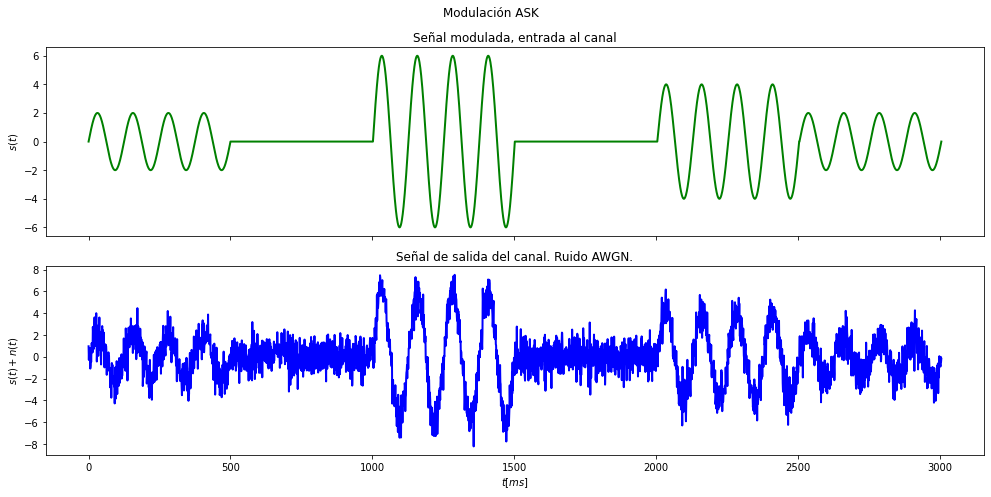

In [6]:
# Visualización de señales. Modulación ASK con Komm.
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14, 7))

# Señal modulada
ax1.plot(x_t, color='g', lw=2)
ax1.set_ylabel('$s(t)$')
ax1.title.set_text('Señal modulada, entrada al canal')

# Señal con ruido
ax2.plot(s_t, color='b', lw=2)
ax2.set_ylabel('$s(t) + n(t)$')
ax2.set_xlabel('$t [ms]$')
ax2.title.set_text('Señal de salida del canal. Ruido AWGN.')
fig.suptitle('Modulación ASK')
fig.tight_layout()
plt.show()